In [63]:
import os
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from snowflake.snowpark import Session, version, Window
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization
import datetime

In [3]:
snowflake_account = '<SNOWFLAKE_DEPLOYMENT>'
snowflake_user = 'USER_HOL_TIMESERIES'
snowflake_role = 'ROLE_HOL_TIMESERIES'
snowflake_warehouse = 'HOL_INGEST_WH'
snowflake_database = 'HOL_TIMESERIES'
snowflake_schema = 'STAGING'

In [4]:
passphrase=''

# Load private key using passphrase
with open('../keys/rsa_key.p8', 'rb') as key:
    p_key = serialization.load_pem_private_key(
        key.read(),
        #password=passphrase.encode(),
        password=None,
        backend=default_backend()
    )

# Set private key for connection
pkb = p_key.private_bytes(
    encoding=serialization.Encoding.DER,
    format=serialization.PrivateFormat.PKCS8,
    encryption_algorithm=serialization.NoEncryption())

In [ ]:
connection_parameters = {
    'account': snowflake_account,
    'user': snowflake_user,
    'private_key': pkb,
    'role': snowflake_role,
    'warehouse': snowflake_warehouse,
    'database': snowflake_database,
    'schema': snowflake_schema
}

# Connect to Snowflake using OAuth
session = Session.builder.configs(connection_parameters).create()

print(session.sql('select current_account(), current_warehouse(), current_database(), current_schema(), current_user(), current_role()').collect())

# Print the current version of the Snowpark library
print(version.VERSION)

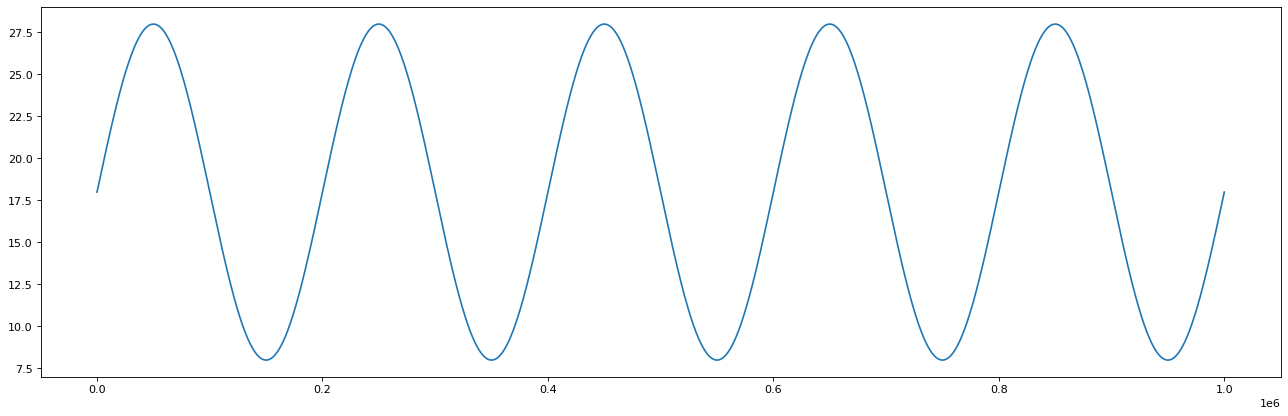

In [375]:
# Generate Sine Data
start = 0
end = 1
sample_rate = 1000000
time = np.arange(start, end, 1/sample_rate)
freq = 5
amplitude = 10
sine = 18 + amplitude * np.sin(2 * np.pi * freq * time)

start_time = datetime.datetime(2024,1,1,0,0,0)

df = pd.DataFrame(sine, columns = ['VALUE'])
df['TRANSACTION'] = df.index + 1
df['TIMESTAMP'] = start_time + pd.to_timedelta(df.index * 10, unit='s')
df=df.reindex(columns = ['TRANSACTION','TIMESTAMP','VALUE'])

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(sine)

In [376]:
df.head(10)

,TRANSACTION,TIMESTAMP,VALUE
0,1,2024-01-01 00:00:00,18.000000
1,2,2024-01-01 00:00:10,18.000314
2,3,2024-01-01 00:00:20,18.000628
3,4,2024-01-01 00:00:30,18.000942
4,5,2024-01-01 00:00:40,18.001257
5,6,2024-01-01 00:00:50,18.001571
6,7,2024-01-01 00:01:00,18.001885
7,8,2024-01-01 00:01:10,18.002199
8,9,2024-01-01 00:01:20,18.002513
9,10,2024-01-01 00:01:30,18.002827


In [377]:
df_snow = session.create_dataframe(df)
# Write out data frame to table
df_snow.write.mode("overwrite").save_as_table("RAW_TS_SINE_DATA")
df_snow.show()

------------------------------------------------------------
|"TRANSACTION"  |"TIMESTAMP"          |"VALUE"             |
------------------------------------------------------------
|1              |2024-01-01 00:00:00  |18.0                |
|2              |2024-01-01 00:00:10  |18.000314159265308  |
|3              |2024-01-01 00:00:20  |18.000628318530303  |
|4              |2024-01-01 00:00:30  |18.00094247779468   |
|5              |2024-01-01 00:00:40  |18.001256637058127  |
|6              |2024-01-01 00:00:50  |18.001570796320337  |
|7              |2024-01-01 00:01:00  |18.00188495558099   |
|8              |2024-01-01 00:01:10  |18.002199114839787  |
|9              |2024-01-01 00:01:20  |18.002513274096412  |
|10             |2024-01-01 00:01:30  |18.002827433350557  |
------------------------------------------------------------



In [378]:
# Sample Sine Data
df_sample = df_snow.sample(None, 10000)
df_sample.show()

df_sample.write.mode("overwrite").save_as_table("RAW_TS_SINESAMPLED_DATA")

df_sample.describe().to_pandas()

------------------------------------------------------------
|"TRANSACTION"  |"TIMESTAMP"          |"VALUE"             |
------------------------------------------------------------
|93205          |2024-01-11 18:54:00  |20.118843011141333  |
|148938         |2024-01-18 05:42:50  |8.005575655298495   |
|970188         |2024-04-22 06:57:50  |9.944500545547884   |
|44564          |2024-01-06 03:47:10  |27.854476791304418  |
|685494         |2024-03-20 08:08:50  |22.401366457947937  |
|498644         |2024-02-27 17:07:10  |18.426185001626962  |
|861966         |2024-04-09 18:20:50  |27.301806978311333  |
|810269         |2024-04-03 18:44:40  |21.170133373247307  |
|350761         |2024-02-10 14:20:00  |8.002850206346139   |
|292645         |2024-02-03 20:54:00  |20.29044092177409   |
------------------------------------------------------------



,SUMMARY,TRANSACTION,VALUE
0,count,10000.000000,10000.000000
1,mean,507582.786100,17.949745
2,stddev,290084.078319,7.082876
3,min,36.000000,8.000000
4,max,999982.000000,28.000000


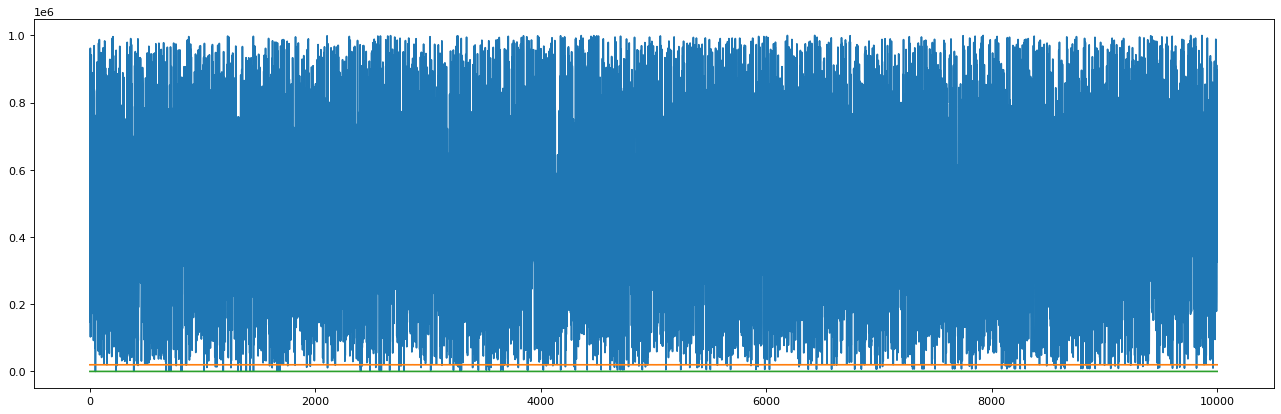

In [379]:
sampled = df_sample.to_pandas()

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(sampled)

,TRANSACTION,TIMESTAMP,VALUE
count,1000000.000000,1000000,1000000.000000
mean,500000.500000,2024-02-27 20:53:14.999997184,3000.003000
min,1.000000,2024-01-01 00:00:00,0.017931
25%,250000.750000,2024-01-29 22:26:37.500000,1499.995502
50%,500000.500000,2024-02-27 20:53:15,3000.008982
75%,750000.250000,2024-03-27 19:19:52.500000,4499.995516
max,1000000.000000,2024-04-25 17:46:30,6000.000000
std,288675.278933,NaN,1732.053406


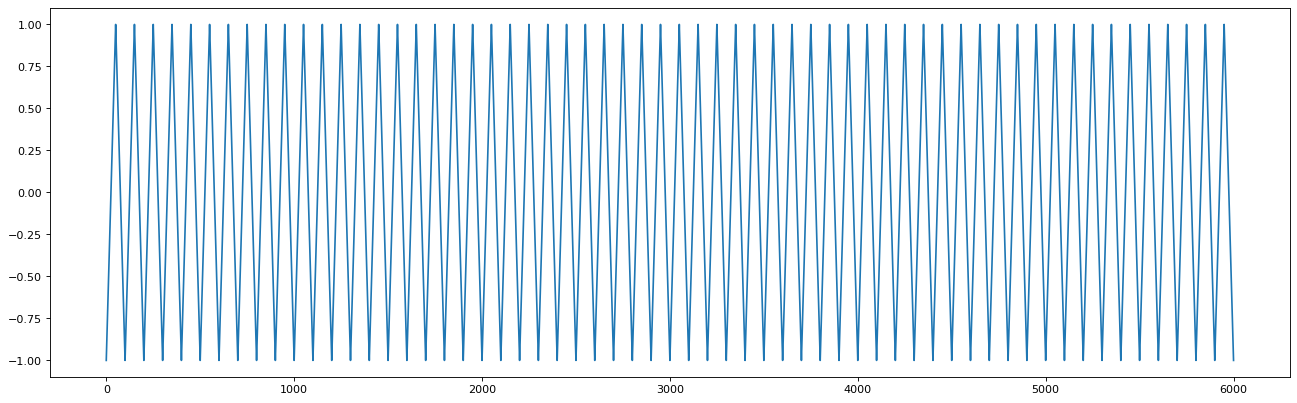

In [459]:
# Generate Sawtooth Data
start = 0
stop = 6000
samples = 1000000

sawt = np.linspace(start, stop, samples)
temp = stop * abs(signal.sawtooth(2 * np.pi * 10000 * sawt, 0.5))

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(sawt, signal.sawtooth(2 * np.pi * 10000 * sawt, 0.5))

df = pd.DataFrame(temp, columns = ['VALUE'])
df['TRANSACTION'] = df.index + 1
df['TIMESTAMP'] = start_time + pd.to_timedelta(df.index * 10, unit='s')
df=df.reindex(columns = ['TRANSACTION','TIMESTAMP','VALUE'])
df.describe()

In [461]:
df.head(1000)

,TRANSACTION,TIMESTAMP,VALUE
0,1,2024-01-01 00:00:00,6000.000000
1,2,2024-01-01 00:00:10,5998.559999
2,3,2024-01-01 00:00:20,5997.119997
3,4,2024-01-01 00:00:30,5995.679996
4,5,2024-01-01 00:00:40,5994.239994
...,...,...,...
995,996,2024-01-01 02:45:50,4567.198567
996,997,2024-01-01 02:46:00,4565.758566
997,998,2024-01-01 02:46:10,4564.318564
998,999,2024-01-01 02:46:20,4562.878563


In [462]:
df_snow = session.create_dataframe(df)
# Write out data frame to table
df_snow.write.mode("overwrite").save_as_table("RAW_TS_SAWTOOTH_DATA")
df_snow.show()

-----------------------------------------------------------
|"TRANSACTION"  |"TIMESTAMP"          |"VALUE"            |
-----------------------------------------------------------
|1              |2024-01-01 00:00:00  |6000.0             |
|2              |2024-01-01 00:00:10  |5998.559998560027  |
|3              |2024-01-01 00:00:20  |5997.119997120054  |
|4              |2024-01-01 00:00:30  |5995.679995680299  |
|5              |2024-01-01 00:00:40  |5994.239994240108  |
|6              |2024-01-01 00:00:50  |5992.799992799918  |
|7              |2024-01-01 00:01:00  |5991.359991360597  |
|8              |2024-01-01 00:01:10  |5989.919989919538  |
|9              |2024-01-01 00:01:20  |5988.479988480217  |
|10             |2024-01-01 00:01:30  |5987.039987040895  |
-----------------------------------------------------------



In [463]:
# Sample Sawtooth Data
df_sample = df_snow.sample(None, 10000)
df_sample.show()

df_sample.write.mode("overwrite").save_as_table("RAW_TS_SAWTOOTHSAMPLED_DATA")

df_sample.describe().to_pandas()

------------------------------------------------------------
|"TRANSACTION"  |"TIMESTAMP"          |"VALUE"             |
------------------------------------------------------------
|835795         |2024-04-06 17:39:00  |2455.4365370834716  |
|845332         |2024-04-07 20:08:30  |722.1426075336042   |
|797269         |2024-04-02 06:38:00  |2067.0681120471445  |
|198336         |2024-01-23 22:55:50  |3602.685595942542   |
|473939         |2024-02-24 20:29:40  |4471.40248057635    |
|107772         |2024-01-13 11:21:50  |5190.395205105215   |
|40910          |2024-01-05 17:38:10  |4909.018913261172   |
|365803         |2024-02-12 08:07:00  |4755.406731070742   |
|852467         |2024-04-08 15:57:40  |2447.7324572266166  |
|696742         |2024-03-21 15:23:30  |1308.0433550236019  |
------------------------------------------------------------



,SUMMARY,TRANSACTION,VALUE
0,count,10000.000000,10000.000000
1,mean,498061.466300,3020.641459
2,stddev,289647.815679,1744.757477
3,min,49.000000,0.162013
4,max,999951.000000,5999.027999
